In [ ]:
!pip install simpletransformers
#SimpleTransformers is an open-source library that allows you to use the power of state-of-the-art transformer models for natural language processing tasks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 250 kB 14.4 MB/s 
     |████████████████████████████████| 5.8 MB 68.7 MB/s 
     |████████████████████████████████| 9.2 MB 55.8 MB/s 
     |████████████████████████████████| 7.6 MB 61.7 MB/s 
     |████████████████████████████████| 1.3 MB 57.2 MB/s 
     |████████████████████████████████| 452 kB 83.5 MB/s 
     |████████████████████████████████| 43 kB 2.7 MB/s 
     |████████████████████████████████| 1.9 MB 58.0 MB/s 
     |████████████████████████████████| 182 kB 79.4 MB/s 
     |████████████████████████████████| 174 kB 62.6 MB/s 
     |████████████████████████████████| 184 kB 75.3 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 173 kB 83.7 MB/s 
     |████████████████████████████████| 168 kB 79.3 MB/s 
     |████████████████████████████████| 168 kB 87.8 MB/s 
     |█████████████████████████████

# Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import GridSearchCV

from simpletransformers.ner import NERModel,NERArgs
from gensim.models import Word2Vec

# Preprocessing for Course Data

In [ ]:
data = pd.read_excel('ML_data.xlsx')
data.head()

,word,course,sentence,tag
0,master,course 0,Sentence 0,O
1,machine,course 0,Sentence 0,B-skill
2,learning,course 0,Sentence 0,I-skill
3,on,course 0,Sentence 0,O
4,python,course 0,Sentence 0,B-skill


In [ ]:
print("Unique words in corpus:", data['word'].nunique())
print("Unique tags in corpus:", data['tag'].nunique())

Crating label encoded versions of the sentence column.

In [ ]:
data["sentence"] = LabelEncoder().fit_transform(data["sentence"])
data.head()

,word,course,sentence,tag
0,master,course 0,0,O
1,machine,course 0,0,B-skill
2,learning,course 0,0,I-skill
3,on,course 0,0,O
4,python,course 0,0,B-skill


In [ ]:
data.rename(columns={"sentence":"sentence_id","word":"words","tag":"labels"}, inplace =True)
data["labels"] = data["labels"].str.upper()
data.head()

,words,course,sentence_id,labels
0,master,course 0,0,O
1,machine,course 0,0,B-SKILL
2,learning,course 0,0,I-SKILL
3,on,course 0,0,O
4,python,course 0,0,B-SKILL


In [ ]:
data.shape

(1808, 4)

## Splitting dataset
80-20 train and test data.
1446 row for train,362 row for test data

In [ ]:
"""X = data[["sentence_id","words"]]
Y = data["labels"]
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size =0.2,random_state=42) 
#building up train data and test data
train_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})
test_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})"""

'X = data[["sentence_id","words"]]\nY = data["labels"]\nx_train, x_test, y_train, y_test = train_test_split(X,Y, test_size =0.2,random_state=42) \n#building up train data and test data\ntrain_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})\ntest_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})'

In [ ]:
X = data[["sentence_id","words"]]
Y = data["labels"]

In [ ]:
x_temp, x_test, y_temp, y_test = train_test_split(X,Y, test_size =0.10,random_state=42) 
x_train, x_val, y_train, y_val = train_test_split(x_temp,y_temp, test_size =0.16,random_state=42)

In [ ]:
train_data = pd.DataFrame({"sentence_id":x_train["sentence_id"],"words":x_train["words"],"labels":y_train})
val_data = pd.DataFrame({"sentence_id":x_val["sentence_id"],"words":x_val["words"],"labels":y_val})
test_data = pd.DataFrame({"sentence_id":x_test["sentence_id"],"words":x_test["words"],"labels":y_test})

In [ ]:
print(train_data.shape)
print(val_data.shape)

print(test_data.shape)


(1366, 3)
(261, 3)
(181, 3)


In [ ]:
train_data

,sentence_id,words,labels
502,147,data,O
459,144,and,O
59,183,model,O
635,162,and,O
526,149,hyperparameters,O
...,...,...,...
996,17,and,O
1300,54,optimization,O
1781,96,advanced,O
1484,70,how,O


In [ ]:
val_data

,sentence_id,words,labels
1298,54,random,O
46,161,and,O
795,179,sentiment,O
784,177,and,O
1057,28,to,O
...,...,...,...
606,159,used,O
989,16,more,O
1240,50,train,O
1337,58,how,O


# NER Model Training

In [ ]:
label = data["labels"].unique().tolist()
label

['O', 'B-SKILL', 'I-SKILL']

## Hyperparameters for NERArgs

num_train_epochs: The number of times the model will see the entire training dataset during training.

learning_rate: The step size at which the optimizer will update the model's weights during training.

overwrite_output_dir: Whether the output directory should be overwritten if it already exists.

train_batch_size: The number of training examples processed in a single batch during training.

eval_batch_size: The number of examples processed in a single batch during evaluation.

In [ ]:
import sklearn.metrics


In [ ]:
args = NERArgs()
args.overwrite_output_dir = True



In [ ]:
num_train_epochs = [4, 6, 8]
learning_rates = [0.01,0.0001, 0.00001] #0.0001,...
batch_sizes = [16, 32, 64]

## BERT
- 'label' is ['O', 'B-SKILL', 'I-SKILL']

- 'bert-base-uncased', is a BERT model trained on a large dataset of lowercased English text.

- 'bert', specifies the type of model to use. In this case, the model is using the BERT (Bidirectional Encoder Representations from Transformers) architecture

- 'args' argument specifies a set of hyperparameters for training the model

In [ ]:
# Store the results in lists
epochs_list = []
learning_rates_list = []
batch_sizes_list = []
results_list = []

for epochs in num_train_epochs:
  for learning_rate in learning_rates:
    for batch_size in batch_sizes:
      args.num_train_epochs = epochs
      args.learning_rate = learning_rate
      args.train_batch_size = batch_size
      args.eval_batch_size = batch_size
      model = NERModel('bert', 'bert-base-uncased', labels = label, args = args)
      model.train_model(train_data, eval_data=val_data, acc=accuracy_score)
      result, model_outputs, preds_list = model.eval_model(val_data)
      

      epochs_list.append(epochs)
      learning_rates_list.append(learning_rate)
      batch_sizes_list.append(batch_size)
      results_list.append(result)
      print("Result: ",result)
      print(f"For:{epochs},{learning_rate},{batch_size} ".format(epochs=epochs,learning_rate=learning_rate,batch_size=batch_size))



Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 4:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Result:  {'eval_loss': 0.5601411908864975, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:4,0.01,16 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.5924156188964844, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:4,0.01,32 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.6422334710756937, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:4,0.01,64 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.2480051111843851, 'precision': 0.7560975609756098, 'recall': 0.7380952380952381, 'f1_score': 0.746987951807229}
For:4,0.0001,16 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.28177961707115173, 'precision': 0.7777777777777778, 'recall': 0.5, 'f1_score': 0.6086956521739131}
For:4,0.0001,32 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.3340798517068227, 'precision': 1.0, 'recall': 0.21428571428571427, 'f1_score': 0.35294117647058826}
For:4,0.0001,64 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.49864785704347825, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:4,1e-05,16 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.6364702701568603, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:4,1e-05,32 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.7258388002713522, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:4,1e-05,64 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.5798355340957642, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:6,0.01,16 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.5991013646125793, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:6,0.01,32 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.611985961596171, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:6,0.01,64 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.34216022170666194, 'precision': 0.717948717948718, 'recall': 0.6666666666666666, 'f1_score': 0.691358024691358}
For:6,0.0001,16 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.26559476256370546, 'precision': 0.8125, 'recall': 0.6190476190476191, 'f1_score': 0.7027027027027026}
For:6,0.0001,32 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.3141181866327922, 'precision': 0.8636363636363636, 'recall': 0.4523809523809524, 'f1_score': 0.59375}
For:6,0.0001,64 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.46203317907121444, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:6,1e-05,16 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.5459701716899872, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:6,1e-05,32 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.6065409978230795, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:6,1e-05,64 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.5650572097963757, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:8,0.01,16 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.5995718359947204, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:8,0.01,32 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.5691869656244913, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:8,0.01,64 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.5230738928981332, 'precision': 0.84375, 'recall': 0.6428571428571429, 'f1_score': 0.7297297297297298}
For:8,0.0001,16 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.3321927636861801, 'precision': 0.84375, 'recall': 0.6428571428571429, 'f1_score': 0.7297297297297298}
For:8,0.0001,32 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.3352292776107788, 'precision': 0.7272727272727273, 'recall': 0.5714285714285714, 'f1_score': 0.64}
For:8,0.0001,64 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.3227158437172572, 'precision': 0.8666666666666667, 'recall': 0.30952380952380953, 'f1_score': 0.45614035087719296}
For:8,1e-05,16 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.5080698668956757, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:8,1e-05,32 


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Result:  {'eval_loss': 0.5866231520970663, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
For:8,1e-05,64 


In [ ]:
results_list

[{'eval_loss': 0.5601411908864975,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 {'eval_loss': 0.5924156188964844,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 {'eval_loss': 0.6422334710756937,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 {'eval_loss': 0.2480051111843851,
  'precision': 0.7560975609756098,
  'recall': 0.7380952380952381,
  'f1_score': 0.746987951807229},
 {'eval_loss': 0.28177961707115173,
  'precision': 0.7777777777777778,
  'recall': 0.5,
  'f1_score': 0.6086956521739131},
 {'eval_loss': 0.3340798517068227,
  'precision': 1.0,
  'recall': 0.21428571428571427,
  'f1_score': 0.35294117647058826},
 {'eval_loss': 0.49864785704347825,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 {'eval_loss': 0.6364702701568603,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 {'eval_loss': 0.7258388002713522,
  'precision': 0.0,
  'recall': 0.0,
  'f1_score': 0.0},
 {'eval_loss': 0.5798355340957642,
  'precision': 0.0,
  'recall

{'eval_loss': 0.3321927636861801,
  'precision': 0.84375,
  'recall': 0.6428571428571429,
  'f1_score': 0.7297297297297298},
For:8,0.0001,32 


In [ ]:
args.num_train_epochs = 8
args.learning_rate = 1e-4
args.train_batch_size = 32
args.eval_batch_size = 32

In [ ]:
model = NERModel('bert', 'bert-base-uncased', labels = label, args = args)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [ ]:
model.train_model(train_data,eval_data = val_data,acc=accuracy_score)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Running Epoch 0 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 2 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/6 [00:00<?, ?it/s]

(48, 0.1812546871272692)

## Results for BERT
Overall, the evaluation results show that the model is performing well, with a low eval loss, high precision, and high F1 score. The recall is somewhat lower than the other metrics, which may indicate that the model is missing some positive examples.

In [ ]:
result, model_outputs, preds_list = model.eval_model(test_data)
result

  0%|          | 0/1 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.49624205380678177,
 'precision': 0.8695652173913043,
 'recall': 0.7142857142857143,
 'f1_score': 0.7843137254901961}

In [ ]:
prediction, model_output = model.predict(["master machine learning on sql"])
prediction

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

[[{'master': 'O'},
  {'machine': 'B-SKILL'},
  {'learning': 'I-SKILL'},
  {'on': 'O'},
  {'sql': 'B-SKILL'}]]

# Most frequent ML engineer skills for calculate similarity


In [ ]:
ML_skills = []

In [ ]:
df_skill = pd.read_csv("ML_skills.csv", header=None, sep=";")
df_skill["skills"] = [row.split("{")[2] for row in df_skill[0]]
df_skill= df_skill.drop(columns=0,axis=1)
df_skill.head()
df_skill['skills'] = df_skill['skills'].apply(lambda x: x.split(", 'skill'")[1])
def clean(text):
    cleaned_text = text[2:-3]
    a = cleaned_text.split(", ")
    a = [i[1:-1] for i in a]
    return a

df_skill["skills"] = df_skill["skills"].apply(clean)
f = lambda x: ','.join(map(str, x)) if isinstance(x, list) else x
df_skill['skills'] = df_skill['skills'].apply(f)
df_skill['skills'] = df_skill['skills'].apply(lambda x: x.replace("'", ''))
df_skill['skills'] = df_skill['skills'].str.lower()

In [ ]:
def remove_duplicate_words(string):
  words = string.split(",")
  unique_words = []

  # iterate through the list of words
  for word in words:
    # if the word is not in the list of unique words, append it
    if word not in unique_words:
      unique_words.append(word)

  # join the list of unique words into a string and return it
  return ", ".join(unique_words)

df_skill["skills"] = df_skill["skills"].apply(remove_duplicate_words)

In [ ]:
df_skill['words'] = df_skill['skills'].apply(lambda x: x.split(","))
word_freq = {}
for row in df_skill['words']:
    for word in row:
        if word not in word_freq:
            word_freq[word] = 1
        else:
            word_freq[word] += 1

In [ ]:
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
top_15_words = sorted_word_freq[:15]
for word, freq in top_15_words:
    ML_skills.append(word)
    print(f'{word}: {freq}')

 python: 63
 java: 60
 c++: 59
 machine learning: 56
 sql: 51
 c: 44
 deep learning: 41
 matlab: 40
 data analysis: 35
 r: 34
 tensorflow: 32
 algorithms: 31
 data mining: 30
 linux: 29
 mysql: 27


In [ ]:
ML_skills

[' python',
 ' java',
 ' c++',
 ' machine learning',
 ' sql',
 ' c',
 ' deep learning',
 ' matlab',
 ' data analysis',
 ' r',
 ' tensorflow',
 ' algorithms',
 ' data mining',
 ' linux',
 ' mysql']

In [ ]:
separated_skills = []
for skill in ML_skills:
  words = skill.split(' ')  # Split the skill on the space character
  separated_skills.extend(words)  # Add the words to the separated_skills list
separated_skills = [skill for skill in separated_skills if skill != '']
print(separated_skills)

['python', 'java', 'c++', 'machine', 'learning', 'sql', 'c', 'deep', 'learning', 'matlab', 'data', 'analysis', 'r', 'tensorflow', 'algorithms', 'data', 'mining', 'linux', 'mysql']


# Reading the ML course phrases

In [ ]:
ML_phrases = pd.read_excel('ML_phrases.xlsx')
ML_phrases

,text,course
0,master machine learning on python r,course 0
1,have a great intuition of many machine learnin...,course 0
2,make accurate predictions,course 0
3,make powerful analysis,course 0
4,make robust machine learning models,course 0
...,...,...
189,multiple linear regression,course 14
190,logistic regression,course 14
191,cluster analysis,course 14
192,kmeans clustering,course 14


## Creating dict includes only skill entities for each courses
Skill entites found earlier by NER

In [ ]:
course_dict = {}
for row in ML_phrases.iterrows():
  row = row[1]
  text = row['text']
  words = text.split()
  course = row['course']
  if course not in course_dict:
    course_dict[course] = []
  entities, _ = model.predict([text])
  lst = []
  for i, word in enumerate(words):
    if(entities[0][i][word]!= 'O'):
      lst.append(word)
  course_dict[course].extend(lst)

In [ ]:
#course_dict

# Word2Vec Model
Loading the word2vec course outcome model. 
  More info. at: 
  
  AIN311_Project/tree/main/word2vec_model

In [ ]:
model = Word2Vec.load("course.model")

In [ ]:
# Find the most similar courses related to most common ML skills
similarities = {}
for course in course_dict:
  entities = course_dict[course]
  sum = 0
  length = 0
  for word in entities:
    for skill in separated_skills:
      try:
        sum+=model.wv.similarity(w1 = word, w2= skill)
        length+=1
      except:
        #print(word, skill)
        continue
  sum/=length #average

  similarities[course] = sum

# RESULT
You can check each course below.

In [ ]:
similarities

{'course 0': 0.8057417311150619,
 'course 1': 0.7306398546436068,
 'course 2': 0.7838463827367287,
 'course 3': 0.7474901828741419,
 'course 4': 0.8415513505989854,
 'course 5': 0.7040747634986824,
 'course 6': 0.5928754869647409,
 'course 7': 0.5259374268917423,
 'course 8': 0.7631879303265702,
 'course 9': 0.8040103361462102,
 'course 10': 0.7753377349087687,
 'course 11': 0.7165623781355944,
 'course 12': 0.7454090995636268,
 'course 13': 0.8243101943622936,
 'course 14': 0.6727199862142662}

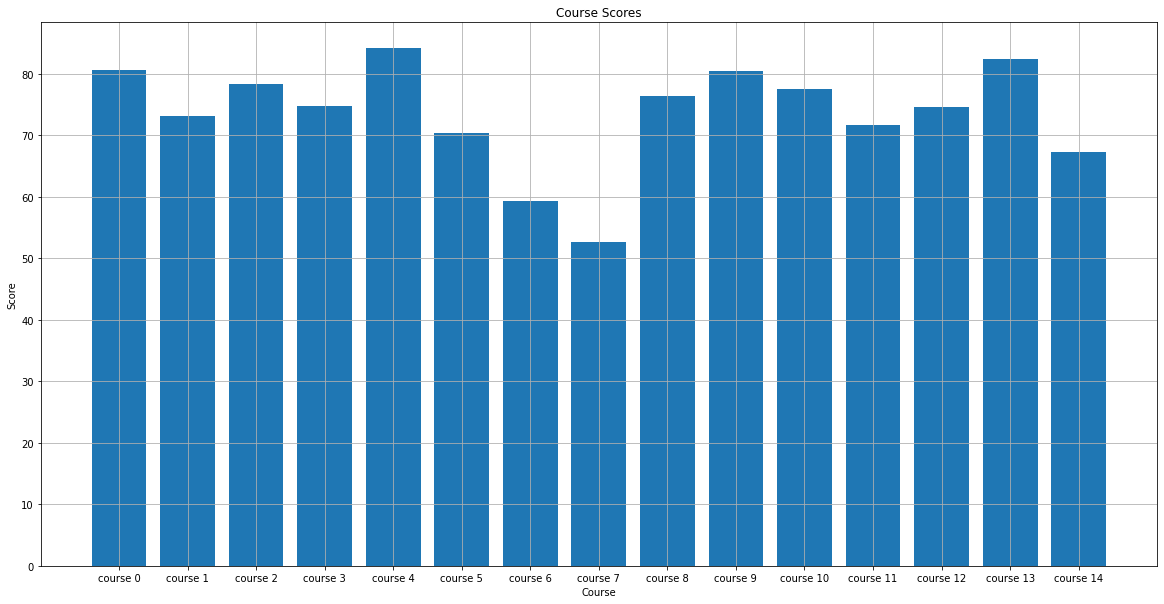

In [ ]:

def y_format(y, pos):
    return '{:,.0f}'.format(y * 100)
fig = plt.figure(figsize=(20, 10))

course_names = list(similarities.keys())
scores = list(similarities.values())

plt.bar(course_names, scores)
plt.xlabel('Course')
plt.ylabel('Score')
plt.title('Course Scores')
formatter = FuncFormatter(y_format)
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid()
plt.show()

- Course 0: https://www.udemy.com/course/machinelearning/

- Course 1: https://www.udemy.com/course/python-for-data-science-and-machine-learning-bootcamp/

- Course 2: https://www.udemy.com/course/python-for-machine-learning-data-science-masterclass/

- Course 3: https://www.udemy.com/course/the-data-science-course-complete-data-science-bootcamp/

- Course 4: https://www.udemy.com/course/feature-engineering-for-machine-learning/

- Course 5: https://www.udemy.com/course/data-science-and-machine-learning-with-python-hands-on/

- Course 6: https://www.udemy.com/course/natural-language-processing-in-python/

- Course 7: https://www.udemy.com/course/deeplearning/

- Course 8: https://www.udemy.com/course/aws-machine-learning/

- Course 9: https://www.udemy.com/course/statsml_x/

- Course 10: https://www.udemy.com/course/data-science-deep-learning-in-python/

- Course 11: https://www.udemy.com/course/machine-learning-with-javascript/

- Course 12: https://www.udemy.com/course/become-an-aws-machine-learning-engineer-in-30-days-new-2022/

- Course 13: https://www.udemy.com/course/data-science-and-machine-learning-bootcamp-with-r/

- Course 14: https://www.udemy.com/course/excel-for-data-science-and-machine-learning/